<a href="https://colab.research.google.com/github/cotrader/versuch/blob/main/Top5_Strategien_Institutionell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Top 5 Trading-Strategien (institutionelles Ranking) – Jupyter Notebook

Quelle: *Collected Articles on Trading Strategies and Backtesting* (Ali Azary)

Dieses Notebook implementiert **5 Strategien als reproduzierbare Templates** (Research → Backtest).
- Daten: `yfinance` (Daily Bars)
- Backtests: überwiegend Pandas/NumPy (schnell & transparent)
- Strategie 2 nutzt `statsmodels` (State-Space / Unobserved Components)

> Hinweis: Das sind **didaktische, robuste Baselines**. Für Echtgeld: Slippage, Fees, Survivorship, Live-Execution, OOS-Tests, Walk-Forward.

Stand: 2026-02-25

## 0) Setup

In [1]:
# Wenn du Pakete vermisst (lokal):
# pip install yfinance pandas numpy matplotlib statsmodels scikit-learn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf


## 1) Hilfsfunktionen (Daten, Indikatoren, Backtest-Basics)

In [2]:
def download_prices(tickers, start="2018-01-01", end=None, interval="1d"):
    """Download Adj Close prices via yfinance and return a clean price DataFrame."""
    end = end or pd.Timestamp.today().strftime("%Y-%m-%d")
    data = yf.download(tickers, start=start, end=end, interval=interval, auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        # auto_adjust=True typically returns single level, but just in case
        if ("Close" in data.columns.get_level_values(0)) or ("Adj Close" in data.columns.get_level_values(0)):
            field = "Close" if "Close" in data.columns.get_level_values(0) else "Adj Close"
            px = data[field].copy()
        else:
            # fallback: take first level if ambiguous
            px = data.xs(data.columns.levels[0][0], axis=1, level=0).copy()
    else:
        # single ticker returns columns
        if "Close" in data.columns:
            px = data["Close"].to_frame(name=tickers if isinstance(tickers, str) else tickers[0])
        else:
            raise ValueError("Could not find Close column in downloaded data.")
    px = px.dropna(how="all")
    px = px.ffill().dropna()
    return px

def returns(prices):
    return prices.pct_change().replace([np.inf, -np.inf], np.nan)

def annualized_sharpe(r, periods_per_year=252):
    r = pd.Series(r).dropna()
    if r.std() == 0 or len(r) < 2:
        return np.nan
    return np.sqrt(periods_per_year) * r.mean() / r.std()

def max_drawdown(equity_curve):
    ec = pd.Series(equity_curve).dropna()
    if ec.empty:
        return np.nan
    peak = ec.cummax()
    dd = (ec / peak) - 1.0
    return dd.min()

def simple_report(strategy_rets, name="Strategy"):
    sr = annualized_sharpe(strategy_rets)
    mdd = max_drawdown((1+strategy_rets.fillna(0)).cumprod())
    cagr = (1+strategy_rets.fillna(0)).prod() ** (252/len(strategy_rets.dropna())) - 1 if len(strategy_rets.dropna())>10 else np.nan
    return pd.Series({
        "Name": name,
        "Sharpe(ann.)": sr,
        "MaxDD": mdd,
        "CAGR(approx.)": cagr,
        "Obs": int(strategy_rets.dropna().shape[0])
    })

# --- Indicators (pure pandas/numpy; no extra deps) ---

def rsi(close, period=14):
    delta = close.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    # Wilder smoothing
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100 / (1 + rs))

def atr(high, low, close, period=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.ewm(alpha=1/period, adjust=False).mean()

def adx(high, low, close, period=14):
    # Wilder's ADX
    up_move = high.diff()
    down_move = -low.diff()
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)

    tr = pd.concat([
        (high - low),
        (high - close.shift(1)).abs(),
        (low - close.shift(1)).abs()
    ], axis=1).max(axis=1)

    atr_w = tr.ewm(alpha=1/period, adjust=False).mean()
    plus_di = 100 * pd.Series(plus_dm, index=close.index).ewm(alpha=1/period, adjust=False).mean() / (atr_w + 1e-12)
    minus_di = 100 * pd.Series(minus_dm, index=close.index).ewm(alpha=1/period, adjust=False).mean() / (atr_w + 1e-12)
    dx = (100 * (plus_di - minus_di).abs() / ((plus_di + minus_di) + 1e-12))
    adx_val = dx.ewm(alpha=1/period, adjust=False).mean()
    return adx_val, plus_di, minus_di


## Daten-Universum (anpassen)
Wähle hier dein Universum. Für schnelle Demos empfehle 10–30 Ticker.

In [3]:
# Beispiel-Universum (ETF/Equities). Du kannst auch Crypto-ETFs oder BTC-USD nutzen.
universe = ["SPY","QQQ","IWM","EFA","EEM","TLT","IEF","GLD","USO","XLK","XLF","XLE"]

prices = download_prices(universe, start="2016-01-01")
retn = returns(prices)

prices.tail(), retn.tail()


(Ticker            EEM         EFA         GLD        IEF         IWM  \
 Date                                                                   
 2026-02-18  61.189999  104.339996  458.279999  97.000000  263.989990   
 2026-02-19  61.040001  104.050003  459.559998  97.089996  264.600006   
 2026-02-20  62.340000  104.900002  468.619995  97.089996  264.609985   
 2026-02-23  61.650002  104.470001  481.279999  97.440002  260.489990   
 2026-02-24  62.619999  104.660004  474.609985  97.419998  263.329987   
 
 Ticker             QQQ         SPY        TLT        USO        XLE  \
 Date                                                                  
 2026-02-18  605.789978  686.289978  89.529999  79.400002  54.779999   
 2026-02-19  603.469971  684.479980  89.620003  81.190002  55.180000   
 2026-02-20  608.809998  689.429993  89.410004  80.849998  54.880001   
 2026-02-23  601.409973  682.390015  89.739998  80.900002  55.150002   
 2026-02-24  607.869995  687.349976  89.900002  80.7600

---

# Strategie 1 (Rank #1): Regime-Filtered Risk-Adjusted Momentum + Inverse Vol Weighting

**Kern:**
- Ranking nach *Risk-Adjusted Momentum* (Return / Volatility)
- **Regime Filter** (z.B. Markt über MA200 → risk-on)
- **Inverse-Vol-Gewichte** (risiko-paritätisch)
- Rebalancing z.B. monatlich

Das entspricht einer sehr “institutionellen” Cross-Asset-Momentum-Routine.

In [6]:
def regime_filter(prices_ref, ma=200):
    """Simple risk-on filter: price above MA => True."""
    ref = prices_ref.dropna()
    return ref > ref.rolling(ma).mean()

def risk_adjusted_momentum_weights(prices, lookback=63, vol_lookback=63, top_k=5):
    """Compute cross-sectional weights based on (lookback return)/(vol), then inverse-vol weighting."""
    r = prices.pct_change(lookback)
    vol = prices.pct_change().rolling(vol_lookback).std()
    score = r / (vol + 1e-12)

    # pick top_k each date
    ranks = score.rank(axis=1, ascending=False, method="first")
    chosen = ranks <= top_k

    inv_vol = 1 / (vol + 1e-12)
    w_raw = inv_vol.where(chosen, 0.0)
    w = w_raw.div(w_raw.sum(axis=1), axis=0).fillna(0.0)
    return w

def backtest_rebalance(prices, weights, rebalance="M", fee_bps=5):
    """Vectorized backtest with discrete rebalancing and simple proportional fees on turnover."""
    daily_r = prices.pct_change().fillna(0.0)

    # rebalance dates
    raw_rb_dates = pd.Series(1, index=prices.index).resample(rebalance).last().index
    # Filter rebalance dates to ensure they exist in the prices.index (and thus w.index)
    rb = raw_rb_dates.intersection(prices.index)
    w = weights.copy().reindex(prices.index).ffill().fillna(0.0)
    # force weights to update only on rebalance dates
    w_rb = w.loc[rb].reindex(prices.index).ffill().fillna(0.0)

    # turnover and fees
    turnover = (w_rb.diff().abs().sum(axis=1)).fillna(0.0)
    fees = turnover * (fee_bps / 1e4)

    strat_r = (w_rb.shift(1) * daily_r).sum(axis=1) - fees
    return strat_r, w_rb, turnover

# --- Build Strategy 1 ---
ref_ticker = "SPY"
risk_on = regime_filter(prices[ref_ticker], ma=200)

w1 = risk_adjusted_momentum_weights(prices, lookback=63, vol_lookback=63, top_k=5)

# Apply regime filter: if risk_off -> all cash (0 weights)
w1 = w1.where(risk_on.reindex(w1.index).fillna(False), 0.0)

r1, w1_rb, to1 = backtest_rebalance(prices, w1, rebalance="M", fee_bps=5)

rep1 = simple_report(r1, "1) Regime Risk-Adj Momentum (InvVol)")
rep1

,0
Name,1) Regime Risk-Adj Momentum (InvVol)
Sharpe(ann.),0.934991
MaxDD,-0.181215
CAGR(approx.),0.105138
Obs,2550


In [ ]:
# Plot equity curve
eq1 = (1+r1).cumprod()
eq1.plot(title="Equity Curve – Strategy 1 (Regime Risk-Adj Momentum)")
plt.show()

# Average weights (top exposures)
w1_rb.mean().sort_values(ascending=False).head(10)


---

# Strategie 2 (Rank #2): State-Space Trend Slope Strategy (Unobserved Components)

**Kern:**
- Log-Preis wird in Trend (Level) + Steigung (Slope) modelliert
- Signal basiert auf der **Trend-Steigung**
- Refit z.B. alle 60–90 Tage mit 1 Jahr Lookback

Diese Logik ist näher an “statistical signal extraction” als an klassische Indikatoren.

In [7]:
import statsmodels.api as sm

def state_space_trend_slope_signal(price, lookback=252, refit_every=63, buy_th=0.001, sell_th=-0.001):
    """Return daily position series based on refit state-space slope."""
    price = price.dropna()
    logp = np.log(price)

    slope = pd.Series(index=logp.index, dtype=float)
    last_fit = None

    for i in range(lookback, len(logp)):
        dt = logp.index[i]
        if (last_fit is None) or ((i - last_fit) >= refit_every):
            window = logp.iloc[i-lookback:i]
            model = sm.tsa.UnobservedComponents(window, level="lltrend")
            res = model.fit(disp=False, method="lbfgs", maxiter=300)
            fs = res.filter_results.filtered_state
            # state: [level, slope]
            slope.loc[dt] = fs[-1, 1]
            last_fit = i
        else:
            slope.loc[dt] = slope.iloc[i-1]  # carry last slope estimate forward

    # position: +1 if slope > buy_th, -1 if slope < sell_th, else hold prior
    pos = pd.Series(0.0, index=logp.index)
    for t in pos.index:
        s = slope.loc[t] if t in slope.index else np.nan
        if pd.isna(s):
            continue
        if s > buy_th:
            pos.loc[t] = 1.0
        elif s < sell_th:
            pos.loc[t] = -1.0
        else:
            pos.loc[t] = pos.shift(1).loc[t] if t != pos.index[0] else 0.0

    return pos, slope

# Example on SPY
pos2, slope2 = state_space_trend_slope_signal(prices["SPY"], lookback=252, refit_every=63, buy_th=0.001, sell_th=-0.001)

r_spy = prices["SPY"].pct_change().fillna(0.0)
r2 = pos2.shift(1).fillna(0.0) * r_spy  # simple, no fee
rep2 = simple_report(r2, "2) State-Space Trend Slope (SPY)")
rep2


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,0
Name,2) State-Space Trend Slope (SPY)
Sharpe(ann.),-0.27937
MaxDD,-0.610781
CAGR(approx.),-0.062191
Obs,2550


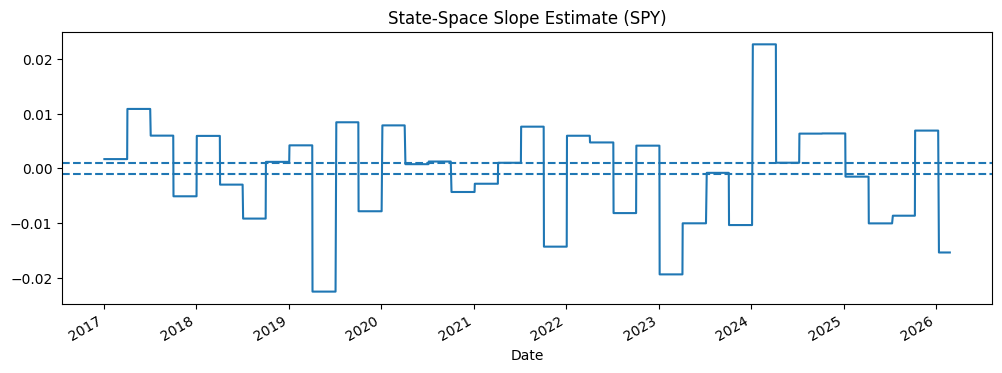

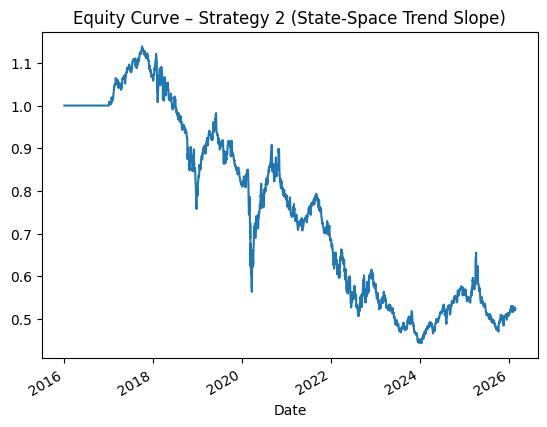

In [8]:
# Visuals
fig, ax = plt.subplots(figsize=(12,4))
slope2.dropna().plot(ax=ax, title="State-Space Slope Estimate (SPY)")
plt.axhline(0.001, linestyle="--")
plt.axhline(-0.001, linestyle="--")
plt.show()

eq2 = (1+r2).cumprod()
eq2.plot(title="Equity Curve – Strategy 2 (State-Space Trend Slope)")
plt.show()


---

# Strategie 3 (Rank #3): Simple Risk-Adjusted Long Momentum (Top-K) + Weekly Stop-Loss Cap

**Kern:**
- Top-K nach (30D Return / 30D Vol)
- 1 Woche halten, wöchentlich neu wählen
- Wenn Wochenrendite < -5% → auf -5% kappen (didaktische Stop-Loss-Näherung)

Das ist eine einfache, aber effektive Momentum-Portfolio-Logik.

In [9]:
def weekly_momentum_stoploss(prices, lookback=30, top_k=5, stop_loss=-0.05):
    """Weekly rebalance momentum with weekly stop loss cap."""
    prices = prices.dropna()
    daily_r = prices.pct_change()

    # weekly endpoints
    w = prices.resample("W-FRI").last()
    # ensure enough history
    w_ret = w.pct_change(lookback)
    w_vol = w.pct_change().rolling(lookback).std()
    score = w_ret / (w_vol + 1e-12)

    # select top_k each week
    ranks = score.rank(axis=1, ascending=False, method="first")
    chosen = ranks <= top_k

    # equal weight among chosen
    weights = chosen.div(chosen.sum(axis=1), axis=0).fillna(0.0)

    # compute weekly portfolio return
    weekly_next = w.pct_change().shift(-1)
    port_weekly = (weights * weekly_next).sum(axis=1)

    # apply stop loss cap
    port_weekly_sl = port_weekly.clip(lower=stop_loss)

    # align to daily (carry weekly return evenly across days for plotting)
    port_weekly_sl = port_weekly_sl.dropna()
    return port_weekly_sl, weights

weekly_r3, w3 = weekly_momentum_stoploss(prices, lookback=8, top_k=5, stop_loss=-0.05)  # 8 weeks ~ 40 trading days
rep3 = pd.Series({
    "Name": "3) Weekly Risk-Adj Momentum + SL (weekly)",
    "Sharpe(ann.)": annualized_sharpe(weekly_r3, periods_per_year=52),
    "MaxDD": max_drawdown((1+weekly_r3.fillna(0)).cumprod()),
    "CAGR(approx.)": (1+weekly_r3.fillna(0)).prod() ** (52/len(weekly_r3)) - 1 if len(weekly_r3)>10 else np.nan,
    "Obs": int(weekly_r3.dropna().shape[0])
})
rep3


,0
Name,3) Weekly Risk-Adj Momentum + SL (weekly)
Sharpe(ann.),0.911897
MaxDD,-0.192352
CAGR(approx.),0.117725
Obs,530


In [ ]:
eq3 = (1+weekly_r3).cumprod()
eq3.plot(title="Equity Curve – Strategy 3 (Weekly Momentum + Stop-Loss Cap)")
plt.show()

w3.tail()


---

# Strategie 4 (Rank #4): ML Classification (Random Forest) → Positionssignal

**Kern:**
- Zielvariable: Buy(1)/Sell(0) aus Trend (z.B. SMA10 > SMA60)
- Features: RSI, ROC, Volatilität, MA-Distanzen
- Modell: RandomForestClassifier
- Backtest: position = model prediction (long/cash)

⚠️ Institutionell wichtig: strikte **TimeSeries Split**, OOS, Purging/Embargo (hier als Basisversion).

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

def build_features(df):
    close = df["Close"]
    feat = pd.DataFrame(index=df.index)
    feat["ret1"] = close.pct_change()
    feat["ret5"] = close.pct_change(5)
    feat["vol20"] = close.pct_change().rolling(20).std()
    feat["rsi14"] = rsi(close, 14)
    feat["sma10"] = close.rolling(10).mean()
    feat["sma60"] = close.rolling(60).mean()
    feat["sma_dist"] = (feat["sma10"] / feat["sma60"]) - 1
    feat["roc10"] = close.pct_change(10)
    feat = feat.replace([np.inf, -np.inf], np.nan).dropna()
    return feat

def ml_classification_strategy(price_series, n_splits=5):
    data = pd.DataFrame({"Close": price_series}).dropna()
    X = build_features(data)

    # target: 1 if sma10 > sma60 else 0
    y = (X["sma10"] > X["sma60"]).astype(int)

    # Align
    X = X.drop(columns=["sma10","sma60"])
    y = y.loc[X.index]

    preds = pd.Series(index=X.index, dtype=float)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]

        model = RandomForestClassifier(
            n_estimators=300,
            max_depth=6,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        p = model.predict(X_test)
        preds.iloc[test_idx] = p

    # Convert to position: long if 1 else 0
    pos = preds.fillna(0.0)
    r = price_series.pct_change().reindex(pos.index).fillna(0.0)
    strat_r = pos.shift(1).fillna(0.0) * r
    acc = accuracy_score(y.loc[preds.dropna().index], preds.dropna().astype(int))
    return strat_r, pos, acc

r4, pos4, acc4 = ml_classification_strategy(prices["SPY"], n_splits=6)
rep4 = simple_report(r4, f"4) ML Classifier (RF) SPY | Acc={acc4:.2f}")
rep4


,0
Name,4) ML Classifier (RF) SPY | Acc=1.00
Sharpe(ann.),0.626403
MaxDD,-0.215218
CAGR(approx.),0.06391
Obs,2491


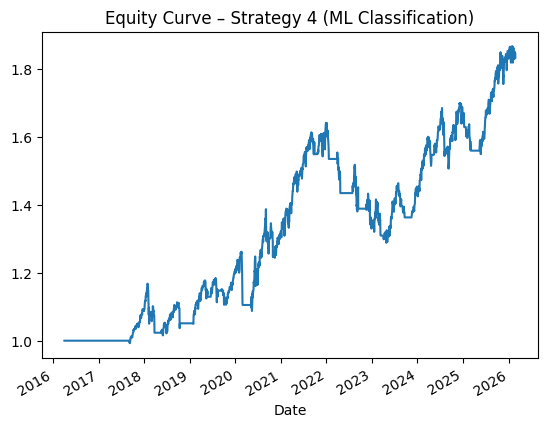

,count
1.0,1589
0.0,902


In [11]:
eq4 = (1+r4).cumprod()
eq4.plot(title="Equity Curve – Strategy 4 (ML Classification)")
plt.show()

pos4.value_counts()


---

# Strategie 5 (Rank #5): RSI Mean-Reversion + ADX Trend Filter + ATR Vol Filter

**Kern:**
- Mean Reversion Entry: RSI < 30 → Long, RSI > 70 → Exit/Flat
- Filter: nur handeln wenn **Trend schwach** (ADX < Schwelle)
- ATR-basierte Volatilitätsfilter / optional Trailing Stop

Das ist eine typische “institutionelle” Reparatur einer einfachen RSI-Strategie:
RSI allein ist oft schlecht → Filter machen sie robust.

In [15]:
def rsi_mean_reversion_filtered(ohlc, rsi_period=14, adx_period=14, atr_period=14,
                               rsi_buy=30, rsi_sell=70, adx_max=20, atr_max_quantile=0.9,
                               fee_bps=2):
    # Ensure high, low, close are simple 1D Series.
    # .squeeze() handles cases where ohlc["High"] might be a single-column DataFrame
    high = ohlc["High"].squeeze()
    low = ohlc["Low"].squeeze()
    close = ohlc["Close"].squeeze()

    _rsi = rsi(close, rsi_period)
    _adx, _, _ = adx(high, low, close, adx_period)
    _atr = atr(high, low, close, atr_period)

    # Vol filter: avoid extreme volatility days
    atr_th = _atr.quantile(atr_max_quantile)
    vol_ok = _atr < atr_th

    # Trend filter: only mean revert in weak-trend regime
    trend_ok = _adx < adx_max

    buy = (_rsi < rsi_buy) & trend_ok & vol_ok
    sell = (_rsi > rsi_sell) | (~trend_ok)  # exit if trend picks up

    pos = pd.Series(0.0, index=close.index)
    in_pos = False
    for t in close.index:
        if not in_pos:
            if bool(buy.loc[t]):
                in_pos = True
                pos.loc[t] = 1.0
            else:
                pos.loc[t] = 0.0
        else:
            if bool(sell.loc[t]):
                in_pos = False
                pos.loc[t] = 0.0
            else:
                pos.loc[t] = 1.0

    r = close.pct_change().fillna(0.0)
    # simple turnover fees
    turnover = pos.diff().abs().fillna(0.0)
    fees = turnover * (fee_bps/1e4)

    strat_r = pos.shift(1).fillna(0.0) * r - fees
    out = {
        "pos": pos,
        "rsi": _rsi,
        "adx": _adx,
        "atr": _atr
    }
    return strat_r, out

# Need OHLC for SPY
ohlc_spy = yf.download("SPY", start="2016-01-01", auto_adjust=False, progress=False)[["High","Low","Close"]].dropna()
r5, aux5 = rsi_mean_reversion_filtered(ohlc_spy, adx_max=20, atr_max_quantile=0.9, fee_bps=2)

rep5 = simple_report(r5, "5) RSI MR + ADX/ATR Filters (SPY)")
rep5

,0
Name,5) RSI MR + ADX/ATR Filters (SPY)
Sharpe(ann.),-0.317179
MaxDD,-0.022422
CAGR(approx.),-0.002239
Obs,2550


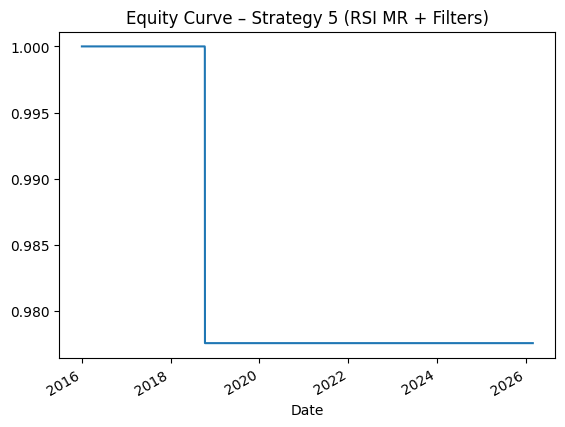

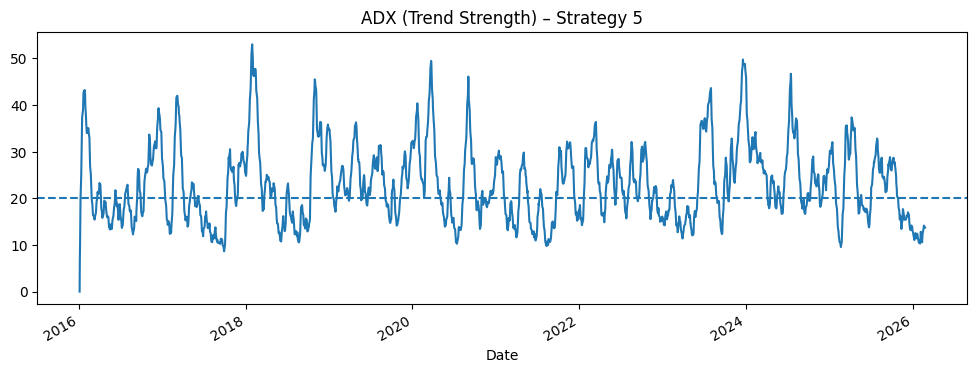

In [16]:
eq5 = (1+r5).cumprod()
eq5.plot(title="Equity Curve – Strategy 5 (RSI MR + Filters)")
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
aux5["adx"].plot(ax=ax, title="ADX (Trend Strength) – Strategy 5")
plt.axhline(20, linestyle="--")
plt.show()


---

# Vergleich & Portfolio-Idee
Hier siehst du die Kennzahlen nebeneinander. (Achtung: unterschiedliche Frequenzen; Strategie 3 ist wöchentlich.)

In [17]:
summary = pd.DataFrame([rep1, rep2, rep4, rep5])
summary


,Name,Sharpe(ann.),MaxDD,CAGR(approx.),Obs
0,1) Regime Risk-Adj Momentum (InvVol),0.934991,-0.181215,0.105138,2550
1,2) State-Space Trend Slope (SPY),-0.279370,-0.610781,-0.062191,2550
2,4) ML Classifier (RF) SPY | Acc=1.00,0.626403,-0.215218,0.063910,2491
3,5) RSI MR + ADX/ATR Filters (SPY),-0.317179,-0.022422,-0.002239,2550


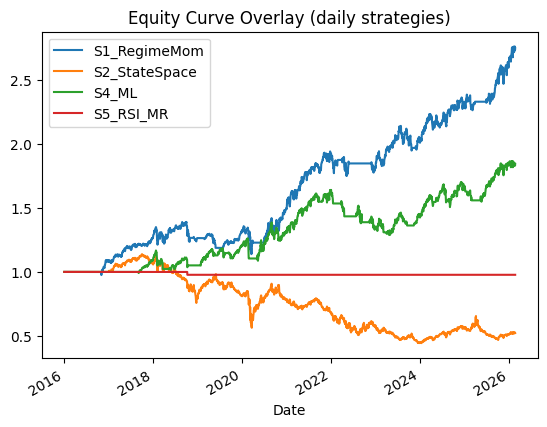

In [18]:
# Equity curves overlay (daily strategies)
eq = pd.DataFrame({
    "S1_RegimeMom": (1+r1).cumprod(),
    "S2_StateSpace": (1+r2.reindex(r1.index).fillna(0)).cumprod(),
    "S4_ML": (1+r4.reindex(r1.index).fillna(0)).cumprod(),
    "S5_RSI_MR": (1+r5.reindex(r1.index).fillna(0)).cumprod(),
}).dropna()

eq.plot(title="Equity Curve Overlay (daily strategies)")
plt.show()


## Next Steps (institutionell)
- Out-of-sample / Walk-forward
- Transaction cost model (slippage + spread)
- Robustness: different universes, different periods
- Risk overlay: volatility targeting, maxDD stop, exposure caps
- Multi-strategy portfolio (risk parity across strategies)

Wenn du willst, baue ich dir daraus als nächstes:
1) ein **Meta-Portfolio** (Strategie-Weights per risk parity), oder  
2) einen **Backtrader/Live-Trading Wrapper** (Cerebro + Broker Adapter), oder  
3) eine **Streamlit UI** (Run, compare, export to Excel/PDF).